# Deep neural network
## Name: Nguyen Anh Hoang Phuc

Classifying layers, etc.

By putting them in a class, we will make the implementation easy to change the configuration.

Places to modify

    Number of layers
    Layer type (other types of layers such as convolutional layers will appear in the future)
    Types of activation functions
    Weight and bias initialization method
    Optimization method


To do this, we create classes for all the coupling layers, for the various activation functions, for the initialisation of weights and biases, and for each of the optimisation methods.

You can implement it freely, but here is a simple example. Create an instance of the fully connected layer and activation function as in sample code 1, and use it as in sample code 2 and 3. Each class will be explained later.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Evaluation index
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
# Download the dataset
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

In [4]:
# Check the data
print(X.shape)      # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X[0].dtype)   # uint8

(60000, 28, 28)
(10000, 28, 28)
uint8


In [5]:
# Smoothing
X_flat = X.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)
print(X_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [6]:
# Type conversion, normalization
X_flat = X_flat.astype(np.float)
X_test_flat = X_test_flat.astype(np.float)
X_flat /= 255
X_test_flat /= 255
print(X_flat.max()) # 1.0
print(X_flat.min()) # 0.0

1.0
0.0


In [7]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64


(60000,)
(60000, 10)
float64


In [8]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [9]:
# Scratch Deep Neural Network (for now, 3 layer NN)
class ScratchSimpleNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output, sigma, n_epoch, n_batch, lr, verbose = False):
        self.n_epoch = n_epoch
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_batch = n_batch
        self.lr = lr
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)

    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
        
    def fit(self, X, y, X_val=False, y_val=False):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        
        optimizer1 = AdaGrad(self.lr)
        optimizer2 = AdaGrad(self.lr)
        optimizer3 = AdaGrad(self.lr)

        initializer1 = XavierInitializer()
        initializer2 = XavierInitializer()
        initializer3 = SimpleInitializer(self.sigma)

        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1, Tanh())
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2, Tanh())
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3, Softmax())

        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

            self.loss = 0

            for mini_X_train, mini_y_train in get_mini_batch:

                # Forward propagation
                self.Z1 = self.FC1.forward(mini_X_train)
                self.Z2 = self.FC2.forward(self.Z1)
                self.Z3 = self.FC3.forward(self.Z2)

                # Back propagation 
                self.dA3 = (self.Z3 - mini_y_train)/self.n_batch
                self.dZ2 = self.FC3.backward(self.dA3)
                self.dZ1 = self.FC2.backward(self.dZ2)
                self.dZ0 = self.FC1.backward(self.dZ1) 

                # Loss function
                self.loss += self.loss_function(self.Z3, mini_y_train)

            # Record the loss function for each epoch
            self.log_loss[epoch] = self.loss/len(get_mini_batch)

            # When verbose is set to true, output the learning process and other information
            if self.verbose:
                print("epoch:{:>3} loss:{:>8,.3f}".format(epoch, self.loss/self.n_batch))

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        pred_Z1 = self.FC1.forward(X)
        pred_Z2 = self.FC2.forward(pred_Z1)

        return np.argmax(self.FC3.forward(pred_Z2), axis=1)


In [10]:
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data 
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]  

    def __iter__(self):
        self._counter = 0
        return self
        
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## Problem 1 Classifying fully connected layers

Please classify the fully connected layer.

Below is a template. Initialize weights and bias in the constructor, and prepare forward and backward methods. By holding the weight W, the bias B, and the forward input X as instance variables, complicated input/output becomes unnecessary.

You can also pass an instance as an argument. Therefore, if you receive the instance initializer of the initialization method in the constructor, it will be initialized. You can change the initialization method by changing the instance to be passed.

You can also pass your self as an argument. You can use this to update the layer weights like self.optimizer.update(self) There are multiple values required for the update, but all can be instance variables of the fully connected layer.

The initialization method and the class of optimization methods are described later.

In [11]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize
        # Initialize self.W and self.B using the initializer method
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)

    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """        
        self.X = X 
        self.A = np.dot(self.X, self.W) + self.B

        return self.activation.forward(self.A)

    def backward(self, dZ):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T, dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)

        # update
        self = self.optimizer.update(self)
        
        return dZ

## Problem 2 Classifying the initialization method

Classify the initialization code.

As mentioned above, we will be able to pass an instance of the initialization method to the constructor of the fully connected layer. Please add the necessary code to the following template. By receiving the standard deviation value (sigma) in the constructor, it is not necessary to pass this value (sigma) in the class of the fully connected layer.

The initialization method we have been dealing with so far will be named the SimpleInitializer class.

In [12]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W :
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B :
        """
        return np.zeros(n_nodes2)

## Problem 3 Classifying optimization methods

Please classify the optimization method.

With respect to the optimization method, it is passed as an instance to the fully connected layer as well as the initialization method. When backward, we can update it as self.optimizer.update(self). Please add the necessary code to the following template.

The optimization methods we have dealt with so far are created as SGD class (Stochastic Gradient Descent).

In [13]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB 
        
        return layer

## Problem 4 Classifying activation functions

Please classify the activation function.

The backpropagation of the softmax function is simplified by implementing it including the calculation of the cross entropy error.

## Evolutionary element

We will implement other than the activation functions, initial values of weights, and optimization methods that we have not seen so far.

In [14]:
class Tanh():
    """
    Activation function: Hyperbolic tangent function
    """
    def __init__(self):
        pass 

    def forward(self,A):
        self.A = A 
        self.Z = np.tanh(self.A)
        return self.Z
    
    def backward(self,dZ):
        return dZ*(1-self.Z**2)

In [15]:
class Sigmoid():
    """
    Activation function: Sigmoid function
    """
    def __init__(self):
        pass 

    def forward(self,A):
        self.A = A 
        self.Z = 1/(1+np.exp(-self.A))
        return self.Z
    
    def backward(self,dZ):
        return dZ*(1-self.Z)*self.Z

In [16]:
class Softmax():
    """
    Activation function: Softmax Function
    """
    def __init__(self):
        pass 

    def forward(self,A):
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)), axis=1, keepdims=True)

    def backward(self,dZ):
        return dZ

## Problem 5 ReLU class creation

Please implement ReLU (Rectified Linear Unit) which is a commonly used activation function as ReLU class.

ReLU is the following formula.

$$
f(x) = ReLU(x) = \begin{cases} x & \text{if $x>0$,}\\ 0 & \text{if $x\leqq0$.} \end{cases}
$$

$x$: A certain feature amount. scalar

In practice, it is possible to usenp.maximumto sum over arrays.

numpy.maximum — NumPy v1.15 Manual

On the other hand, the derivative of $f(x)$ with respect to $x$ for backpropagation is

$$ \frac{\partial f(x)}{\partial x} = \begin{cases} 1 & \text{if $x>0$,}\\ 0 & \text{if $x\leqq0$. } \end{cases} $$ 

It is not mathematically differentiable, but it corresponds by setting $0$ when $x=0$.

Whether or not $x$ in the forward direction determines whether the gradient is backpropagated or not.

In [17]:
class ReLU():
    """
    Activation function: ReLU function
    """
    def __init(self):
        pass

    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)

    def backward(self, dZ):
        return np.where(self.A>0, dZ, 0)

In [18]:
a = np.array([-1,0,1,9,-1])
b = np.array([1,0,-1,9,-1])

print(np.where(a<0,0,b))

[ 0  0 -1  9  0]


## Problem 6 Initial value of weight

So far, the initial values of weights and bias have been simply Gaussian distributions, and standard deviation has been treated as a hyperparameter. However, it is known what value it should be. For sigmoidal and hyperbolic tangent functions, the initial value of Xavier (or the initial value of Glorot) is used, and for ReLU the initial value of He.

Create XavierI nitializer class and HeIn itializer class.

## Initial value of Xavier

The standard deviation $\sigma$ at the initial value of Xavier is calculated by the following formula.

$$ \sigma = \frac{1}{\sqrt{n}} $$

$n$: number of nodes in the previous layer

"paper"

Glorot, X., & Bengio, Y. (nd). Understanding the difficulty of training deep feedforward neural networks.

## Initial value of He

The standard deviation $\sigma$ of the initial value of He is calculated by the following formula.

$$ \sigma = \sqrt{\frac{2}{n}} $$

$n$: number of nodes in the previous layer

"paper"

He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.

In [19]:
class XavierInitializer():
    """
    Initializing weights with Xavier
    """
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        """
        Initializeing weights
        Parameters
        -------------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the subsequent layer
        
        Returns
        ---------
        W: weight
        """
        return np.random.randn(n_nodes1, n_nodes2)/np.sqrt(n_nodes1)

    def B(self, n_nodes2):
        """
        Bias Initialization
        Parameters
        -------------
        n_nodes2 : int
          Number of nodes in the subsequent layer
        
        Returns
        ---------
        B: bias
        """
        return np.zeros(n_nodes2)

In [20]:
class HeInitializer():
    """
    Initializing weights by He
    """
    def __init__(self):
        pass

    def W(self, n_nodes1, n_nodes2):
        """
        Initializeing weights
        Parameters
        -------------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the subsequent layer
        
        Returns
        ---------
        W: weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)

    def B(self, n_nodes2):
        """
        Bias Initialization
        Parameters
        -------------
        n_nodes2 : int
          Number of nodes in the subsequent layer
        
        Returns
        ---------
        B: bias
        """
        return np.zeros(n_nodes2)

## Problem 7 Optimization method

The most common method is to vary the learning rate in the learning process. Please create a class of AdaGrad which is the basic method.

First, check the SGD you have been using so far.

$$ W_i^{\prime} = W_i-\alpha E(\frac{\partial L}{\partial W_i}) \\ B_i^{\prime} = B_i-\alpha E(\frac{\partial L} {\partial B_i}) $$

$\alpha$ : Learning rate (can be different for each layer, but basically all the same)）

$\frac{\partial L}{\partial W_i}$ : Gradient of loss $L$ with respect to $W_i$.

$\frac{\partial L}{\partial B_i}$ : Gradient of loss $L$ with respect to $B_i$.

$E()$: Calculates the vector average in the direction of the mini-batch

Next is AdaGrad. The bias formula is omitted, but it does something similar to weighting.

The learning rate for the weight is gradually reduced by the updated amount. Save the gradient sum of squares $H$ for each iteration and reduce the learning rate accordingly.

The learning rate will be different for each weight.

$$ H_i^{\prime} = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\ W_i^{\prime} = W_i-\alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\ $$

$H_i$: Sum of squares of the gradient up to the previous iteration for the i-th layer (initial value is 0)

$H_i^{\prime}$: Updated $H_i$

"paper"

Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).

In [21]:
class AdaGrad:
    """
    Stochastic gradient descent method
    Parameters
    ------------
    lr: learning rate
    """
    def __init__(self, lr):
        self.lr = lr 
        self.hW = 0
        self.hB = 0

    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer: An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB 

        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) + (1e-7))
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) + (1e-7))

        return layer

## Problem 8 Class completion

Complete the Scratch Deep Neural Netrowk Classifier class that can be trained and estimated with any configuration.

In [22]:
clf = ScratchSimpleNeuralNetrowkClassifier(n_epoch=5, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, sigma=0.01, n_batch=100, lr=0.01, verbose=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

epoch:  0 loss:   0.143
epoch:  1 loss:   0.078
epoch:  2 loss:   0.061
epoch:  3 loss:   0.050
epoch:  4 loss:   0.043


In [23]:
print(y_pred)

accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred)
print("accuracy: {:.3f}".format(accuracy))

[4 3 7 ... 1 7 4]
accuracy: 0.964


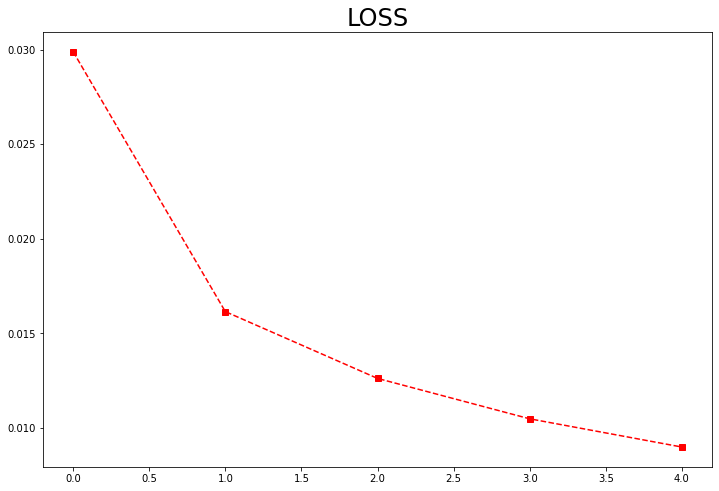

In [24]:
# Visualize the loss function for each epoch
fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20

plt.title("LOSS")
plt.plot(clf.log_loss, 'rs--')

## Problem 9 Learning and estimation

Create several networks with varying numbers of layers and activation functions. Then, train and estimate the MNIST data and calculate the Accuracy.

In [25]:
# Scratch Deep Neural Network (if you can do it in any layer)
class ScratchDNNClassifier():
    """
    N Layer neural Network classifier
    Parameters
    ----------
    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, NN, n_epoch, n_batch, verbose = False):
        # Parameters
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN

    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
        
    def accuracy(self, Z, Y):
        return accuracy_score(Y, Z)

    def fit(self, X, y, X_val=False, y_val=False):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

            self.loss = 0

            for mini_X_train, mini_y_train in get_mini_batch:

                # Forward propagation
                forward_data = mini_X_train
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                # Predicted value
                Z = forward_data 

                # Back propagation 
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1, -1, -1):
                    backward_data = self.NN[layer].backward(backward_data)

                # Loss function
                self.loss += self.loss_function(Z, mini_y_train)

            # Record the loss function for each epoch
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X), np.argmax(y, axis=1))

            # When verbose is set to true, output the learning process and other information
            if self.verbose:
                print("epoch:{:>3} loss:{:>8,.3f}".format(epoch, self.loss/self.n_batch))

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        pred_data = X

        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)

        return np.argmax(pred_data, axis=1)


## Verification 1
- 3 layers (784 -> 400 -> 200 -> 10)
- Activation function for layer 1: ReLU function
- Activation function for layer 2: ReLU function
- Activation function for 3 layers: Softmax function\
- Optimization method: AdaGrad

In [26]:
NN2 = {0: FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
       1: FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       2: FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax())}

In [27]:
clf2 = ScratchDNNClassifier(NN=NN2, n_epoch=30, n_batch=20, verbose=True)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_valid)

epoch:  0 loss:   2.525
epoch:  1 loss:   1.266
epoch:  2 loss:   1.000
epoch:  3 loss:   0.853
epoch:  4 loss:   0.745
epoch:  5 loss:   0.650
epoch:  6 loss:   0.581
epoch:  7 loss:   0.524
epoch:  8 loss:   0.483
epoch:  9 loss:   0.445
epoch: 10 loss:   0.418
epoch: 11 loss:   0.394
epoch: 12 loss:   0.371
epoch: 13 loss:   0.371
epoch: 14 loss:   0.347
epoch: 15 loss:   0.331
epoch: 16 loss:   0.311
epoch: 17 loss:   0.305
epoch: 18 loss:   0.327
epoch: 19 loss:   0.333
epoch: 20 loss:   0.319
epoch: 21 loss:   0.310
epoch: 22 loss:   0.279
epoch: 23 loss:   0.248
epoch: 24 loss:   0.213
epoch: 25 loss:   0.200
epoch: 26 loss:   0.197
epoch: 27 loss:   0.173
epoch: 28 loss:   0.194
epoch: 29 loss:   0.162


In [28]:
print(y_pred2)

accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred2)
print("accuracy: {:.3f}".format(accuracy))

[4 3 7 ... 1 7 4]
accuracy: 0.972


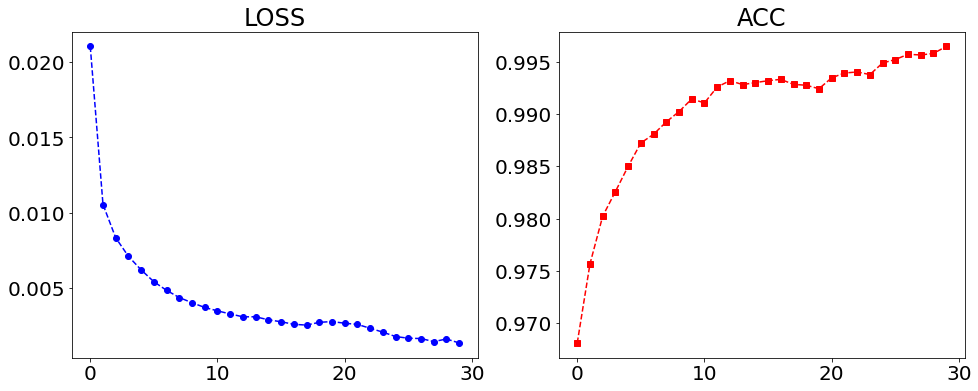

In [29]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(clf2.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(clf2.log_acc, 'rs--')

## Search 2
- 4 layers (784 -> 400 -> 600 -> 300 -> 10)
- layer 1: ReLU
- layer 2: ReLU
- layer 3: ReLU 
- layer 4: Softmax 
- Optimization method: AdaGrad

In [30]:
NN3 = {0: FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
       1: FC(400, 600, HeInitializer(), AdaGrad(0.01), ReLU()),
       2: FC(600, 300, HeInitializer(), AdaGrad(0.01), ReLU()),
       3: FC(300, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax())}

In [31]:
clf3 = ScratchDNNClassifier(NN=NN3, n_epoch=30, n_batch=20, verbose=True)
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_valid)

epoch:  0 loss:   2.387
epoch:  1 loss:   1.043
epoch:  2 loss:   0.763
epoch:  3 loss:   0.597
epoch:  4 loss:   0.507
epoch:  5 loss:   0.458
epoch:  6 loss:   0.422
epoch:  7 loss:   0.387
epoch:  8 loss:   0.395
epoch:  9 loss:   0.382
epoch: 10 loss:   0.299
epoch: 11 loss:   0.301
epoch: 12 loss:   0.331
epoch: 13 loss:   0.269
epoch: 14 loss:   0.227
epoch: 15 loss:   0.205
epoch: 16 loss:   0.157
epoch: 17 loss:   0.192
epoch: 18 loss:   0.228
epoch: 19 loss:   0.212
epoch: 20 loss:   0.210
epoch: 21 loss:   0.256
epoch: 22 loss:   0.165
epoch: 23 loss:   0.177
epoch: 24 loss:   0.254
epoch: 25 loss:   0.155
epoch: 26 loss:   0.231
epoch: 27 loss:   0.083
epoch: 28 loss:   0.100
epoch: 29 loss:   0.125


In [32]:
print(y_pred3)

accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred3)
print("accuracy: {:.3f}".format(accuracy))

[4 3 7 ... 1 7 4]
accuracy: 0.972


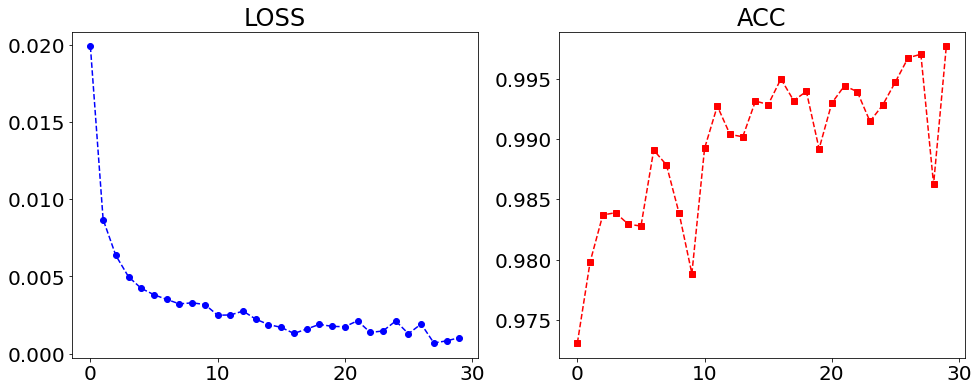

In [33]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(clf3.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(clf3.log_acc, 'rs--')


## Search 3
- 5 layers (784, 400, 300, 200, 100, 10)
- layer 1: Tanh
- layer 2: Sigmoid
- layer 3: ReLU 
- layer 4: ReLU
- layer 5: Softmax 
- Optimization method: AdaGrad

In [34]:
NN4 = {0: FC(784, 400, HeInitializer(), AdaGrad(0.01), Tanh()),
       1: FC(400, 300, HeInitializer(), AdaGrad(0.01), Sigmoid()),
       2: FC(300, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       3: FC(200, 100, HeInitializer(), AdaGrad(0.01), ReLU()),
       4: FC(100, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax())}

In [35]:
clf4 = ScratchDNNClassifier(NN=NN4, n_epoch=30, n_batch=20, verbose=True)
clf4.fit(X_train, y_train)
y_pred4 = clf4.predict(X_valid)

epoch:  0 loss:   3.550
epoch:  1 loss:   1.713
epoch:  2 loss:   1.330
epoch:  3 loss:   1.115
epoch:  4 loss:   0.965
epoch:  5 loss:   0.852
epoch:  6 loss:   0.771
epoch:  7 loss:   0.715
epoch:  8 loss:   0.679
epoch:  9 loss:   0.653
epoch: 10 loss:   0.648
epoch: 11 loss:   0.635
epoch: 12 loss:   0.614
epoch: 13 loss:   0.603
epoch: 14 loss:   0.564
epoch: 15 loss:   0.508
epoch: 16 loss:   0.470
epoch: 17 loss:   0.447
epoch: 18 loss:   0.399
epoch: 19 loss:   0.355
epoch: 20 loss:   0.328
epoch: 21 loss:   0.319
epoch: 22 loss:   0.321
epoch: 23 loss:   0.288
epoch: 24 loss:   0.261
epoch: 25 loss:   0.254
epoch: 26 loss:   0.215
epoch: 27 loss:   0.200
epoch: 28 loss:   0.185
epoch: 29 loss:   0.170


In [36]:
print(y_pred4)

accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred4)
print("accuracy: {:.3f}".format(accuracy))

[4 3 7 ... 1 7 4]
accuracy: 0.971


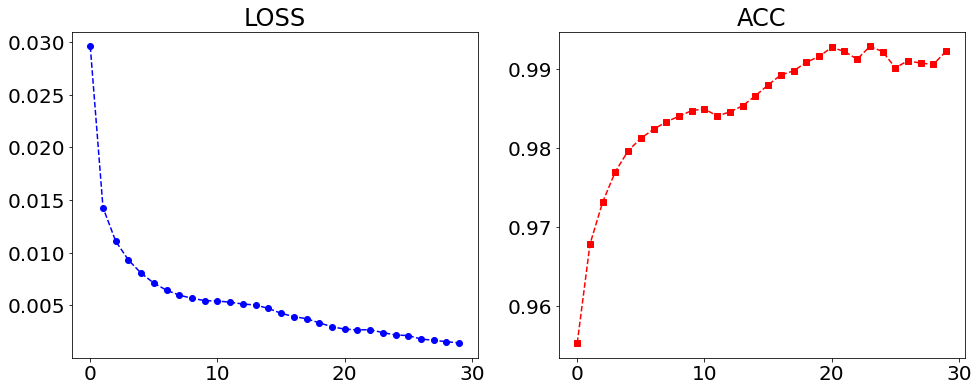

In [37]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(clf4.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(clf4.log_acc, 'rs--')


## Verification 4

In [38]:
NN5 = {0: FC(784, 400, HeInitializer(), AdaGrad(0.01), Tanh()),
       1: FC(400, 300, HeInitializer(), AdaGrad(0.01), ReLU()),
       2: FC(300, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       3: FC(200, 100, HeInitializer(), AdaGrad(0.01), ReLU()),
       4: FC(100, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax())}

In [39]:
clf5 = ScratchDNNClassifier(NN=NN5, n_epoch=30, n_batch=20, verbose=True)
clf5.fit(X_train, y_train)
y_pred5 = clf5.predict(X_valid)

epoch:  0 loss:   2.747
epoch:  1 loss:   1.223
epoch:  2 loss:   0.926
epoch:  3 loss:   0.770
epoch:  4 loss:   0.667
epoch:  5 loss:   0.613
epoch:  6 loss:   0.592
epoch:  7 loss:   0.589
epoch:  8 loss:   0.569
epoch:  9 loss:   0.633
epoch: 10 loss:   0.641
epoch: 11 loss:   0.592
epoch: 12 loss:   0.560
epoch: 13 loss:   0.538
epoch: 14 loss:   0.529
epoch: 15 loss:   0.581
epoch: 16 loss:   0.501
epoch: 17 loss:   0.452
epoch: 18 loss:   0.342
epoch: 19 loss:   0.258
epoch: 20 loss:   0.340
epoch: 21 loss:   0.355
epoch: 22 loss:   0.277
epoch: 23 loss:   0.312
epoch: 24 loss:   0.334
epoch: 25 loss:   0.350
epoch: 26 loss:   0.273
epoch: 27 loss:   0.266
epoch: 28 loss:   0.213
epoch: 29 loss:   0.183


In [40]:
print(y_pred4)

accuracy = accuracy_score(np.argmax(y_valid, axis=1), y_pred5)
print("accuracy: {:.3f}".format(accuracy))

[4 3 7 ... 1 7 4]
accuracy: 0.971


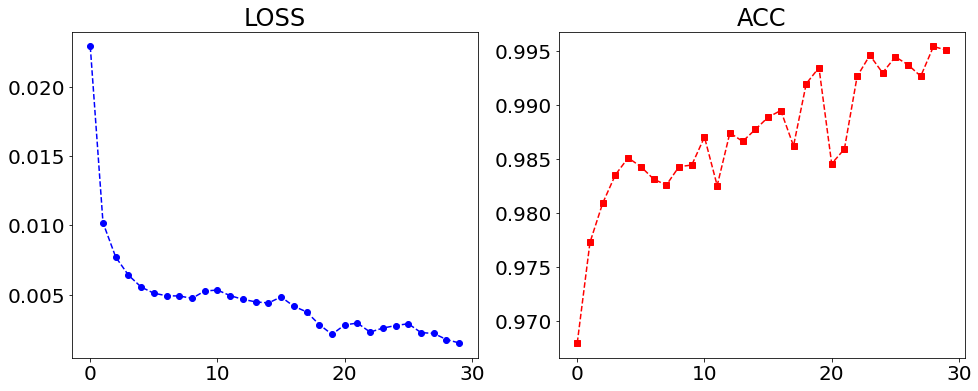

In [41]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("LOSS")
plt.plot(clf5.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title("ACC")
plt.plot(clf5.log_acc, 'rs--')


It seems that a deeper layer is not always better